In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score
import kerastuner as kt
import IPython
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import r2_score

C:\Users\jame1\AppData\Local\Temp\ipykernel_14136\2473793395.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
df = pd.read_csv('mergeVincesnoAtipicos.csv', sep=';', low_memory=False)
df

,Index,_1,Identificador,year,rc_clacul,ct_prepa_suelo,ct_k510ha,ct_k511ha,ct_afecta_prod,ct_riego,...,pq_herb,ct_color_her_pq,pq_ins,ct_color_ins_pq,pq_fun,ct_color_fun_pq,su_plaguicidas,ct_prod,Ventas,Unnamed: 28
0,168,12678,12085002062560003,2018,507,1,0.0706,0.0706,2,1,...,0.5,4,0.5,1,0.5,4,0.0706,0.272727,0.181818,NaN
1,172,12683,12085002062560004,2018,507,1,0.5000,0.5000,2,1,...,1.0,3,1.0,2,0.0,0,0.5000,4.363636,1.818182,NaN
2,171,12682,12085002062560004,2018,507,1,0.5000,0.5000,2,1,...,1.0,3,1.0,2,0.0,0,0.5000,4.363636,1.818182,NaN
3,170,12681,12085002062560004,2018,507,1,0.5000,0.5000,2,2,...,1.0,3,1.0,2,0.0,0,0.5000,4.363636,1.818182,NaN
4,169,12680,12085002062560004,2018,507,1,0.5000,0.5000,3,2,...,1.0,3,1.0,2,0.0,0,0.5000,4.363636,1.818182,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,163,16815,12085151000993398,2017,507,2,4.9392,4.9392,7,2,...,7.0,3,2.0,4,0.0,0,4.9392,16.838182,16.838182,NaN
475,162,16813,12085151000993398,2017,507,2,9.8784,9.8784,7,2,...,14.0,3,4.0,3,0.0,0,9.8784,33.676364,33.676364,NaN
476,167,16821,12085152000990314,2017,507,1,5.0000,5.0000,7,1,...,0.0,0,2.0,1,9.0,1,5.0000,11.697955,11.697955,NaN
477,166,16820,12085152000990314,2017,507,1,5.0000,5.0000,7,1,...,0.0,0,2.0,1,9.0,1,5.0000,11.697955,11.697955,NaN


In [3]:
columnas_SVM = ['ct_prepa_suelo', 'ct_k510ha', 'ct_k511ha', 'ct_afecta_prod',
                'ct_riego', 'su_fertilizada', 'ct_fqui', 'ct_fqui_npk',
                'ct_pqui', 'su_plaguicidas']

X = df[columnas_SVM]
y= df.ct_prod

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, test_size = 0.2)
print(f"Shape of X_train = {X_train.shape}\nShape of y_train = {y_train.shape}\nShape if X_valid : {X_valid.shape}\nShape of y_valid = {y_valid.shape}")

Shape of X_train = (383, 10)
Shape of y_train = (383,)
Shape if X_valid : (96, 10)
Shape of y_valid = (96,)


In [5]:
# Preprocessing

num_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]
cat_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['object']]

si = SimpleImputer(strategy = 'constant')
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

pp_pipeline = ColumnTransformer(
transformers = [
    ('num', si, num_cols),
    ('cat', ohe, cat_cols)
])

pp_X_train = pp_pipeline.fit_transform(X_train)
pp_X_valid = pp_pipeline.transform(X_valid)
print(pp_X_train.shape)
print(pp_X_valid.shape)

(383, 10)
(96, 10)


In [6]:
model = Sequential()
model.add(Dense(pp_X_train.shape[-1], input_shape = (pp_X_train.shape[-1],)))
model.add(Dense(45, activation = 'relu'))
model.add(Dense(1, activation  = 'linear'))


model.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mean_absolute_error'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 45)                495       
                                                                 
 dense_2 (Dense)             (None, 1)                 46        
                                                                 
Total params: 651
Trainable params: 651
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
epochs = 100
trained_model = model.fit(pp_X_train, y_train, epochs = epochs, validation_data = (pp_X_valid, y_valid))

Epoch 1/100
12/12 [==============================] - 1s 12ms/step - loss: 18.9477 - mean_absolute_error: 18.9477 - val_loss: 8.4570 - val_mean_absolute_error: 8.4570
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 6.7851 - mean_absolute_error: 6.7851 - val_loss: 5.5920 - val_mean_absolute_error: 5.5920
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 4.8765 - mean_absolute_error: 4.8765 - val_loss: 3.2517 - val_mean_absolute_error: 3.2517
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 3.6145 - mean_absolute_error: 3.6145 - val_loss: 3.1628 - val_mean_absolute_error: 3.1628
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 3.5660 - mean_absolute_error: 3.5660 - val_loss: 3.0551 - val_mean_absolute_error: 3.0551
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 3.8581 - mean_absolute_error: 3.8581 - val_loss: 3.3955 - val_mean_absolute_error: 3.3955
Epoch 7/100
12/12 [

Epoch 51/100
12/12 [==============================] - 0s 3ms/step - loss: 3.0019 - mean_absolute_error: 3.0019 - val_loss: 2.5541 - val_mean_absolute_error: 2.5541
Epoch 52/100
12/12 [==============================] - 0s 3ms/step - loss: 2.7771 - mean_absolute_error: 2.7771 - val_loss: 4.2693 - val_mean_absolute_error: 4.2693
Epoch 53/100
12/12 [==============================] - 0s 3ms/step - loss: 3.8263 - mean_absolute_error: 3.8263 - val_loss: 3.8071 - val_mean_absolute_error: 3.8071
Epoch 54/100
12/12 [==============================] - 0s 3ms/step - loss: 4.0314 - mean_absolute_error: 4.0314 - val_loss: 2.5780 - val_mean_absolute_error: 2.5780
Epoch 55/100
12/12 [==============================] - 0s 3ms/step - loss: 2.9133 - mean_absolute_error: 2.9133 - val_loss: 3.4604 - val_mean_absolute_error: 3.4604
Epoch 56/100
12/12 [==============================] - 0s 3ms/step - loss: 3.2295 - mean_absolute_error: 3.2295 - val_loss: 2.1412 - val_mean_absolute_error: 2.1412
Epoch 57/100
12/

Training MAE : 2.6729159355163574
Validation MAE : 3.4280941486358643


<Figure size 640x480 with 0 Axes>

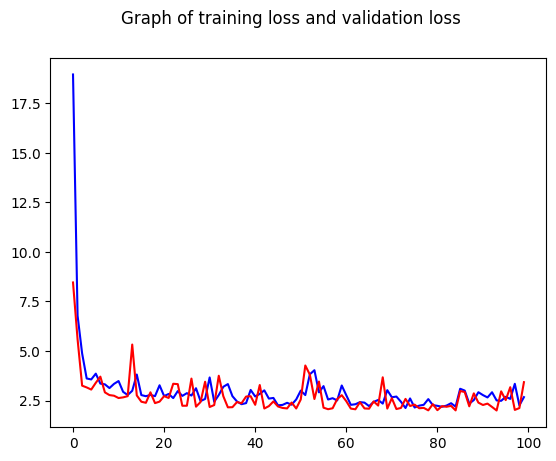

In [8]:
#Plot the decrease of MAE with each iteration
print(f"Training MAE : {trained_model.history['loss'][-1]}")
print(f"Validation MAE : {trained_model.history['val_loss'][-1]}")
import matplotlib.pyplot as plt
plt.clf()
fig = plt.figure()
fig.suptitle('Graph of training loss and validation loss')
plt.plot(range(epochs), trained_model.history['loss'], 'b', range(epochs), trained_model.history['val_loss'], 'r')

In [9]:
def model_builder(hp):
    model = Sequential()
    model.add(Dense(pp_X_train.shape[-1], input_shape = (pp_X_train.shape[-1],)))
    hp_units = hp.Int('units', min_value = 10, max_value = 180, step = 45)
    model.add(Dense(units = hp_units, activation = 'relu'))
    model.add(Dense(units = hp_units, activation = 'relu'))
    model.add(Dense(units = hp_units, activation = 'relu'))
    model.add(Dense(units = hp_units, activation = 'relu'))
    # Give the last layer
    model.add(Dense(1, activation = 'linear'))
    
    #Create HP for learning rate
    hp_learn_rate = hp.Choice('learning rate', values = [1e-4, 1e-3, 1e-2, 1e-1])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learn_rate), 
                  loss = keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),
                  metrics = [keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None)])
    return model

In [10]:
tuner = kt.RandomSearch(model_builder,
                        objective = 'val_loss',
                        max_trials=10,
                        executions_per_trial=5,
                        directory = 'output',
                        project_name = 'MLPRegressor')
# Code Taken from intro to tensorflow core
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)
    
tuner.search(pp_X_train, y_train, epochs = 25, validation_data = (pp_X_valid, y_valid), callbacks = [ClearTrainingOutput()])
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 3)[0]

INFO:tensorflow:Reloading Tuner from output\MLPRegressor\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [11]:
at_model = tuner.hypermodel.build(best_hps)
print(at_model.summary())
epochs = 100
at_trained_model = at_model.fit(pp_X_train, y_train, epochs = epochs, validation_data = (pp_X_valid, y_valid))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 55)                605       
                                                                 
 dense_5 (Dense)             (None, 55)                3080      
                                                                 
 dense_6 (Dense)             (None, 55)                3080      
                                                                 
 dense_7 (Dense)             (None, 55)                3080      
                                                                 
 dense_8 (Dense)             (None, 1)                 56        
                                                                 
Total params: 10,011
Trainable params: 10,011
Non-trai

12/12 [==============================] - 0s 3ms/step - loss: 2.3291 - mean_absolute_error: 2.3291 - val_loss: 2.3318 - val_mean_absolute_error: 2.3318
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 2.3510 - mean_absolute_error: 2.3510 - val_loss: 2.8235 - val_mean_absolute_error: 2.8235
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 2.6239 - mean_absolute_error: 2.6239 - val_loss: 2.5879 - val_mean_absolute_error: 2.5879
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 2.4777 - mean_absolute_error: 2.4777 - val_loss: 2.5440 - val_mean_absolute_error: 2.5440
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 2.4631 - mean_absolute_error: 2.4631 - val_loss: 2.3865 - val_mean_absolute_error: 2.3865
Epoch 48/100
12/12 [==============================] - 0s 3ms/step - loss: 2.4769 - mean_absolute_error: 2.4769 - val_loss: 2.7635 - val_mean_absolute_error: 2.7635
Epoch 49/100
12/12 [=========

12/12 [==============================] - 0s 3ms/step - loss: 2.1821 - mean_absolute_error: 2.1821 - val_loss: 2.2272 - val_mean_absolute_error: 2.2272
Epoch 94/100
12/12 [==============================] - 0s 3ms/step - loss: 2.3331 - mean_absolute_error: 2.3331 - val_loss: 2.4553 - val_mean_absolute_error: 2.4553
Epoch 95/100
12/12 [==============================] - 0s 3ms/step - loss: 2.2021 - mean_absolute_error: 2.2021 - val_loss: 2.6098 - val_mean_absolute_error: 2.6098
Epoch 96/100
12/12 [==============================] - 0s 3ms/step - loss: 2.4136 - mean_absolute_error: 2.4136 - val_loss: 2.5934 - val_mean_absolute_error: 2.5934
Epoch 97/100
12/12 [==============================] - 0s 3ms/step - loss: 2.3044 - mean_absolute_error: 2.3044 - val_loss: 2.4459 - val_mean_absolute_error: 2.4459
Epoch 98/100
12/12 [==============================] - 0s 3ms/step - loss: 2.2982 - mean_absolute_error: 2.2982 - val_loss: 2.4046 - val_mean_absolute_error: 2.4046
Epoch 99/100
12/12 [=========

Training MAE : 2.2280852794647217
Validation MAE : 2.236886739730835


<Figure size 640x480 with 0 Axes>

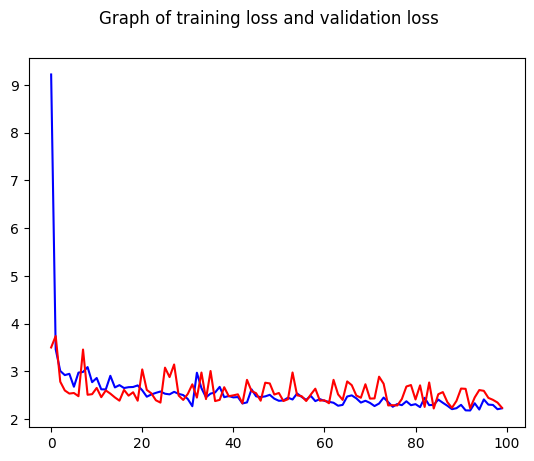

In [12]:
#Plot the decrease of MAE with each iteration
print(f"Training MAE : {at_trained_model.history['loss'][-1]}")
print(f"Validation MAE : {at_trained_model.history['val_loss'][-1]}")
import matplotlib.pyplot as plt
plt.clf()
fig = plt.figure()
fig.suptitle('Graph of training loss and validation loss')
plt.plot(range(epochs), at_trained_model.history['loss'], 'b', range(epochs), at_trained_model.history['val_loss'], 'r')

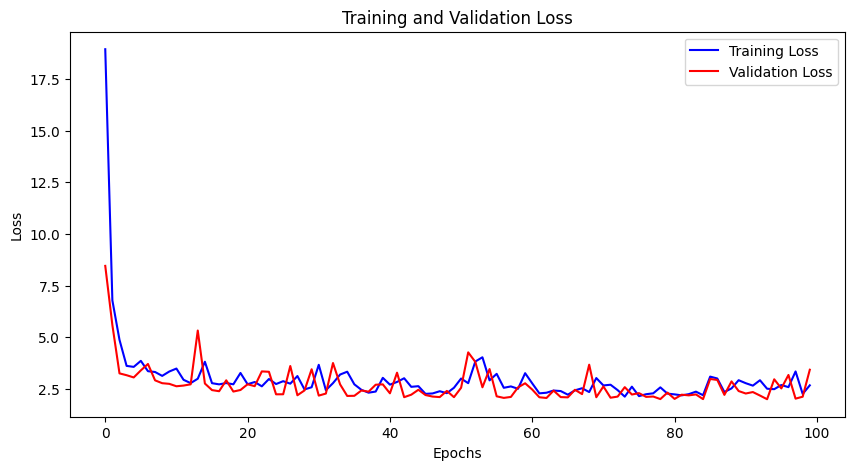

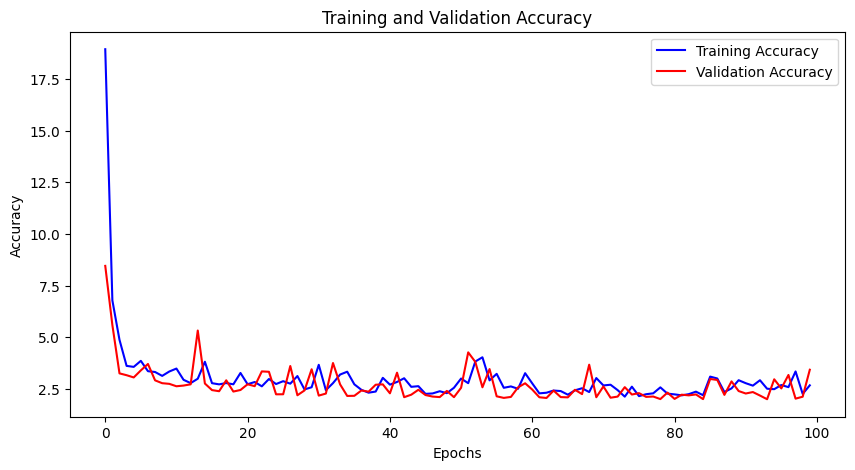

In [13]:
# Obtener la pérdida y precisión del modelo entrenado
train_loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
train_acc = trained_model.history['mean_absolute_error']
val_acc = trained_model.history['val_mean_absolute_error']

# Graficar la pérdida (loss) durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_loss, 'b', label='Training Loss')
plt.plot(range(epochs), val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar la precisión (accuracy) durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_acc, 'b', label='Training Accuracy')
plt.plot(range(epochs), val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
import pandas as pd
# Predicciones en datos de prueba
test_predictions = model.predict(pp_X_valid)
# Crear un diccionario con los nuevos datos
nuevos_datos_dict = {
    'ct_prepa_suelo': [1],
    'ct_k510ha': [0.0706],
    'ct_k511ha': [0.0706],
    'ct_afecta_prod': [2],
    'ct_riego': [1],
    'su_fertilizada': [0.0706],
    'ct_fqui': [1],
    'ct_fqui_npk': [1102.3],
    'ct_pqui': [1],
    'su_plaguicidas': [0.0706],
    'Ventas': [0.181818]
}

# Crear el DataFrame con los nuevos datos
nuevos_datos = pd.DataFrame(nuevos_datos_dict)

# Realizar el preprocesamiento en los nuevos datos
pp_nuevos_datos = pp_pipeline.transform(nuevos_datos)

# Realizar las predicciones en base a los nuevos datos preprocesados
predicciones = model.predict(pp_nuevos_datos)

# Imprimir las predicciones
print("La prediccion es: ", predicciones)

# Calcular el R2 score
r2 = r2_score(y_valid, test_predictions)
print("R2 Score:", r2)

1/1 [==============================] - 0s 31ms/step
La prediccion es:  [[11.604789]]
R2 Score: 0.0871721630442408


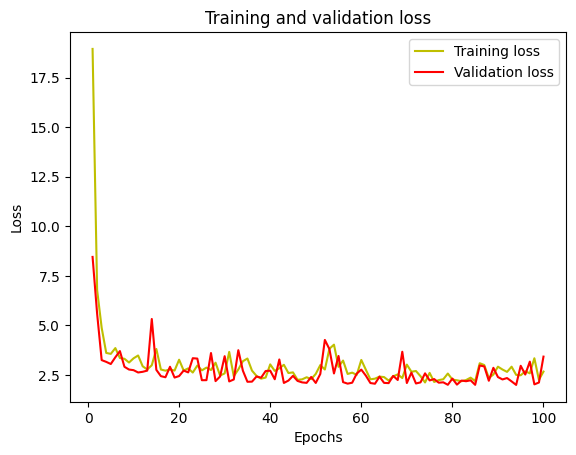

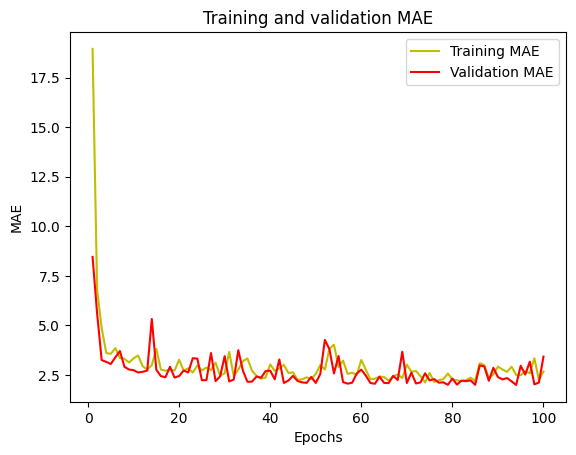

In [15]:

# Plot the training and validation loss at each epoch
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation MAE at each epoch
acc = trained_model.history['mean_absolute_error']
val_acc = trained_model.history['val_mean_absolute_error']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# ... (resto del código)
